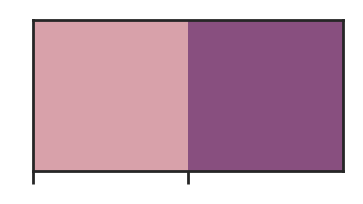

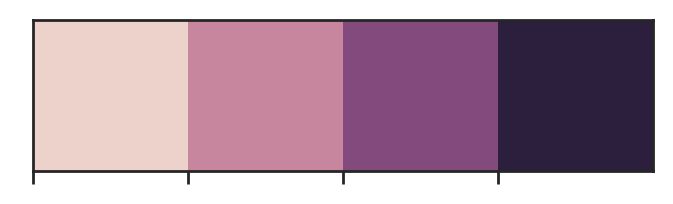

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

from scipy import interpolate
from sklearn import svm
from arviz import hpd

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 


#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Consistent color map throughout
cpal = sns.cubehelix_palette(4)
cmap = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)
tt_cmap = sns.cubehelix_palette(2, light=0.7, dark=0.4, as_cmap=True)
tt_cpal = sns.cubehelix_palette(2, light=0.7, dark=0.4, as_cmap=False)

sns.set_palette(cpal)
sns.palplot(tt_cpal)
sns.palplot(cpal)

fig_overwrite = False

### Load the CKS VII table (merged with several literature tables)
This table is the output of the merge-tables.ipynb notebook

In [2]:
cks = pd.read_parquet('../data/cks-merged.parquet')

### Empirical open cluster gyrochrones ([Curtis et al. 2020](https://arxiv.org/abs/2010.02272))
We will use published gyrochrones derived from open clusters to empirically age-rank planet hosts

In [3]:
# Curtis et al. 2020 table
def curtis_bprp_teff(bprp):
    #Estimating effective temperature from the dereddened Gaia DR2 (Bp-Rp) color
    bprp  = np.array(bprp)
    coeff = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5, -2694.76, 192.865]    
    teff  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=0.55) & (bprp<=3.25)
    teff[~mask] = np.nan
    return teff

def curtis_gyrochrone(bprp, kind):
    bprp = np.array(bprp)
    
    if kind=='kepler': #Kepler lower envelope
        bprp_min, bprp_max = 0.6, 2.1
        coeff = [36.4756, -202.718, 414.752, -395.161, 197.800, -50.0287, 5.05738]
        
    elif kind=='pleiades-ro':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [37.068, -188.02, 332.32, -235.78, 60.395]

    elif kind=='pleiades-quad':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [-8.467, 19.64, -5.438]
        
    elif kind=='praesepe':
        bprp_min, bprp_max = 0.6, 2.4
        coeff = [-330.810, 1462.48, -2569.35, 2347.13, -1171.90, 303.620, -31.9227]
        
    elif kind=='ngc6811':
        bprp_min, bprp_max = 0.65, 1.95 
        coeff = [-594.019, 2671.90, -4791.80, 4462.64, -2276.40, 603.772, -65.0830]
        
    elif kind=='ngc752':
        bprp_min, bprp_max = 1.32, 2.24
        coeff = [6.80, 5.63] 
    
    elif kind=='ngc6819+ruprecht147':
        bprp_min, bprp_max = 0.62, 2.07
        coeff = [-271.783, 932.879, -1148.51, 695.539, -210.562, 25.8119]
        
    prot  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=bprp_min) & (bprp<=bprp_max)
    prot[~mask] = np.nan
    
    return prot
        
    
#Re-casting the Curtis et al. 2020 polynomial relations in Teff
#bprp = np.linspace(0,5,1000)
#teff = curtis_bprp_teff(bprp)

from scipy import interpolate

def curtis_teff_gyrochrone(teff, kind):
    
    _bprp = np.linspace(0,5,10000)
    _teff = curtis_bprp_teff(_bprp)
    _prot = curtis_gyrochrone(_bprp, kind)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_prot))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _prot[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)


def curtis_teff_bprp(teff):
    #Invert Teff-BpRp relation
    
    _bprp = np.linspace(0.55,3.25,10000)
    _teff = curtis_bprp_teff(_bprp)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_bprp))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _bprp[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)

### Compute gyrochronology ages using Stardate
This takes a few minutes

In [4]:
from stardate.lhf import age_model
cks['sd_age'] = np.nan*np.ones(len(cks))
cks['sd_age_phot'] = np.nan*np.ones(len(cks))
cks['sd_age_gaia'] = np.nan*np.ones(len(cks))

from tqdm import tqdm

for i in tqdm(range(len(cks))):
    if (cks['f18_Teff'][i]<=6400) & (curtis_teff_bprp(cks['f18_Teff'][i])>0) & (np.isfinite(cks['prot'][i])):
        cks['sd_age'][i] = age_model(np.log10(cks['prot'][i]), curtis_teff_bprp(cks['f18_Teff'][i]))
        cks['sd_age_phot'][i] = age_model(np.log10(cks['prot'][i]), curtis_teff_bprp(cks['b20_iso_teff'][i]))
    if (cks['f18_Teff'][i]<=6400) & (np.isfinite(cks['gaia_bp_rp'][i])):        
        cks['sd_age_gaia'][i] = age_model(np.log10(cks['prot'][i]), cks['gaia_bp_rp'][i])
    else:
        pass

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
100%|██████████| 1913/1913 [05:20<00:00,  5.97it/s]


### MIST v1.1 isochrones
For plotting and sample selection purposes

In [5]:
#Non-rotating solar metallicity MIST isochrones
mist  = np.genfromtxt('../data/isochrones/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Non-rotating Fe/H = -0.25 MIST isochrones
mistm = np.genfromtxt('../data/isochrones/MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Non-rotating Fe/H = +0.25 MIST isochrones
mistp = np.genfromtxt('../data/isochrones/MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Rotating (v/vcrit=0.4) solar metallicity MIST isochrones
mistr = np.genfromtxt('../data/isochrones/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso', skip_header=10, names=True)

### Sample selection and masking of unreliable data

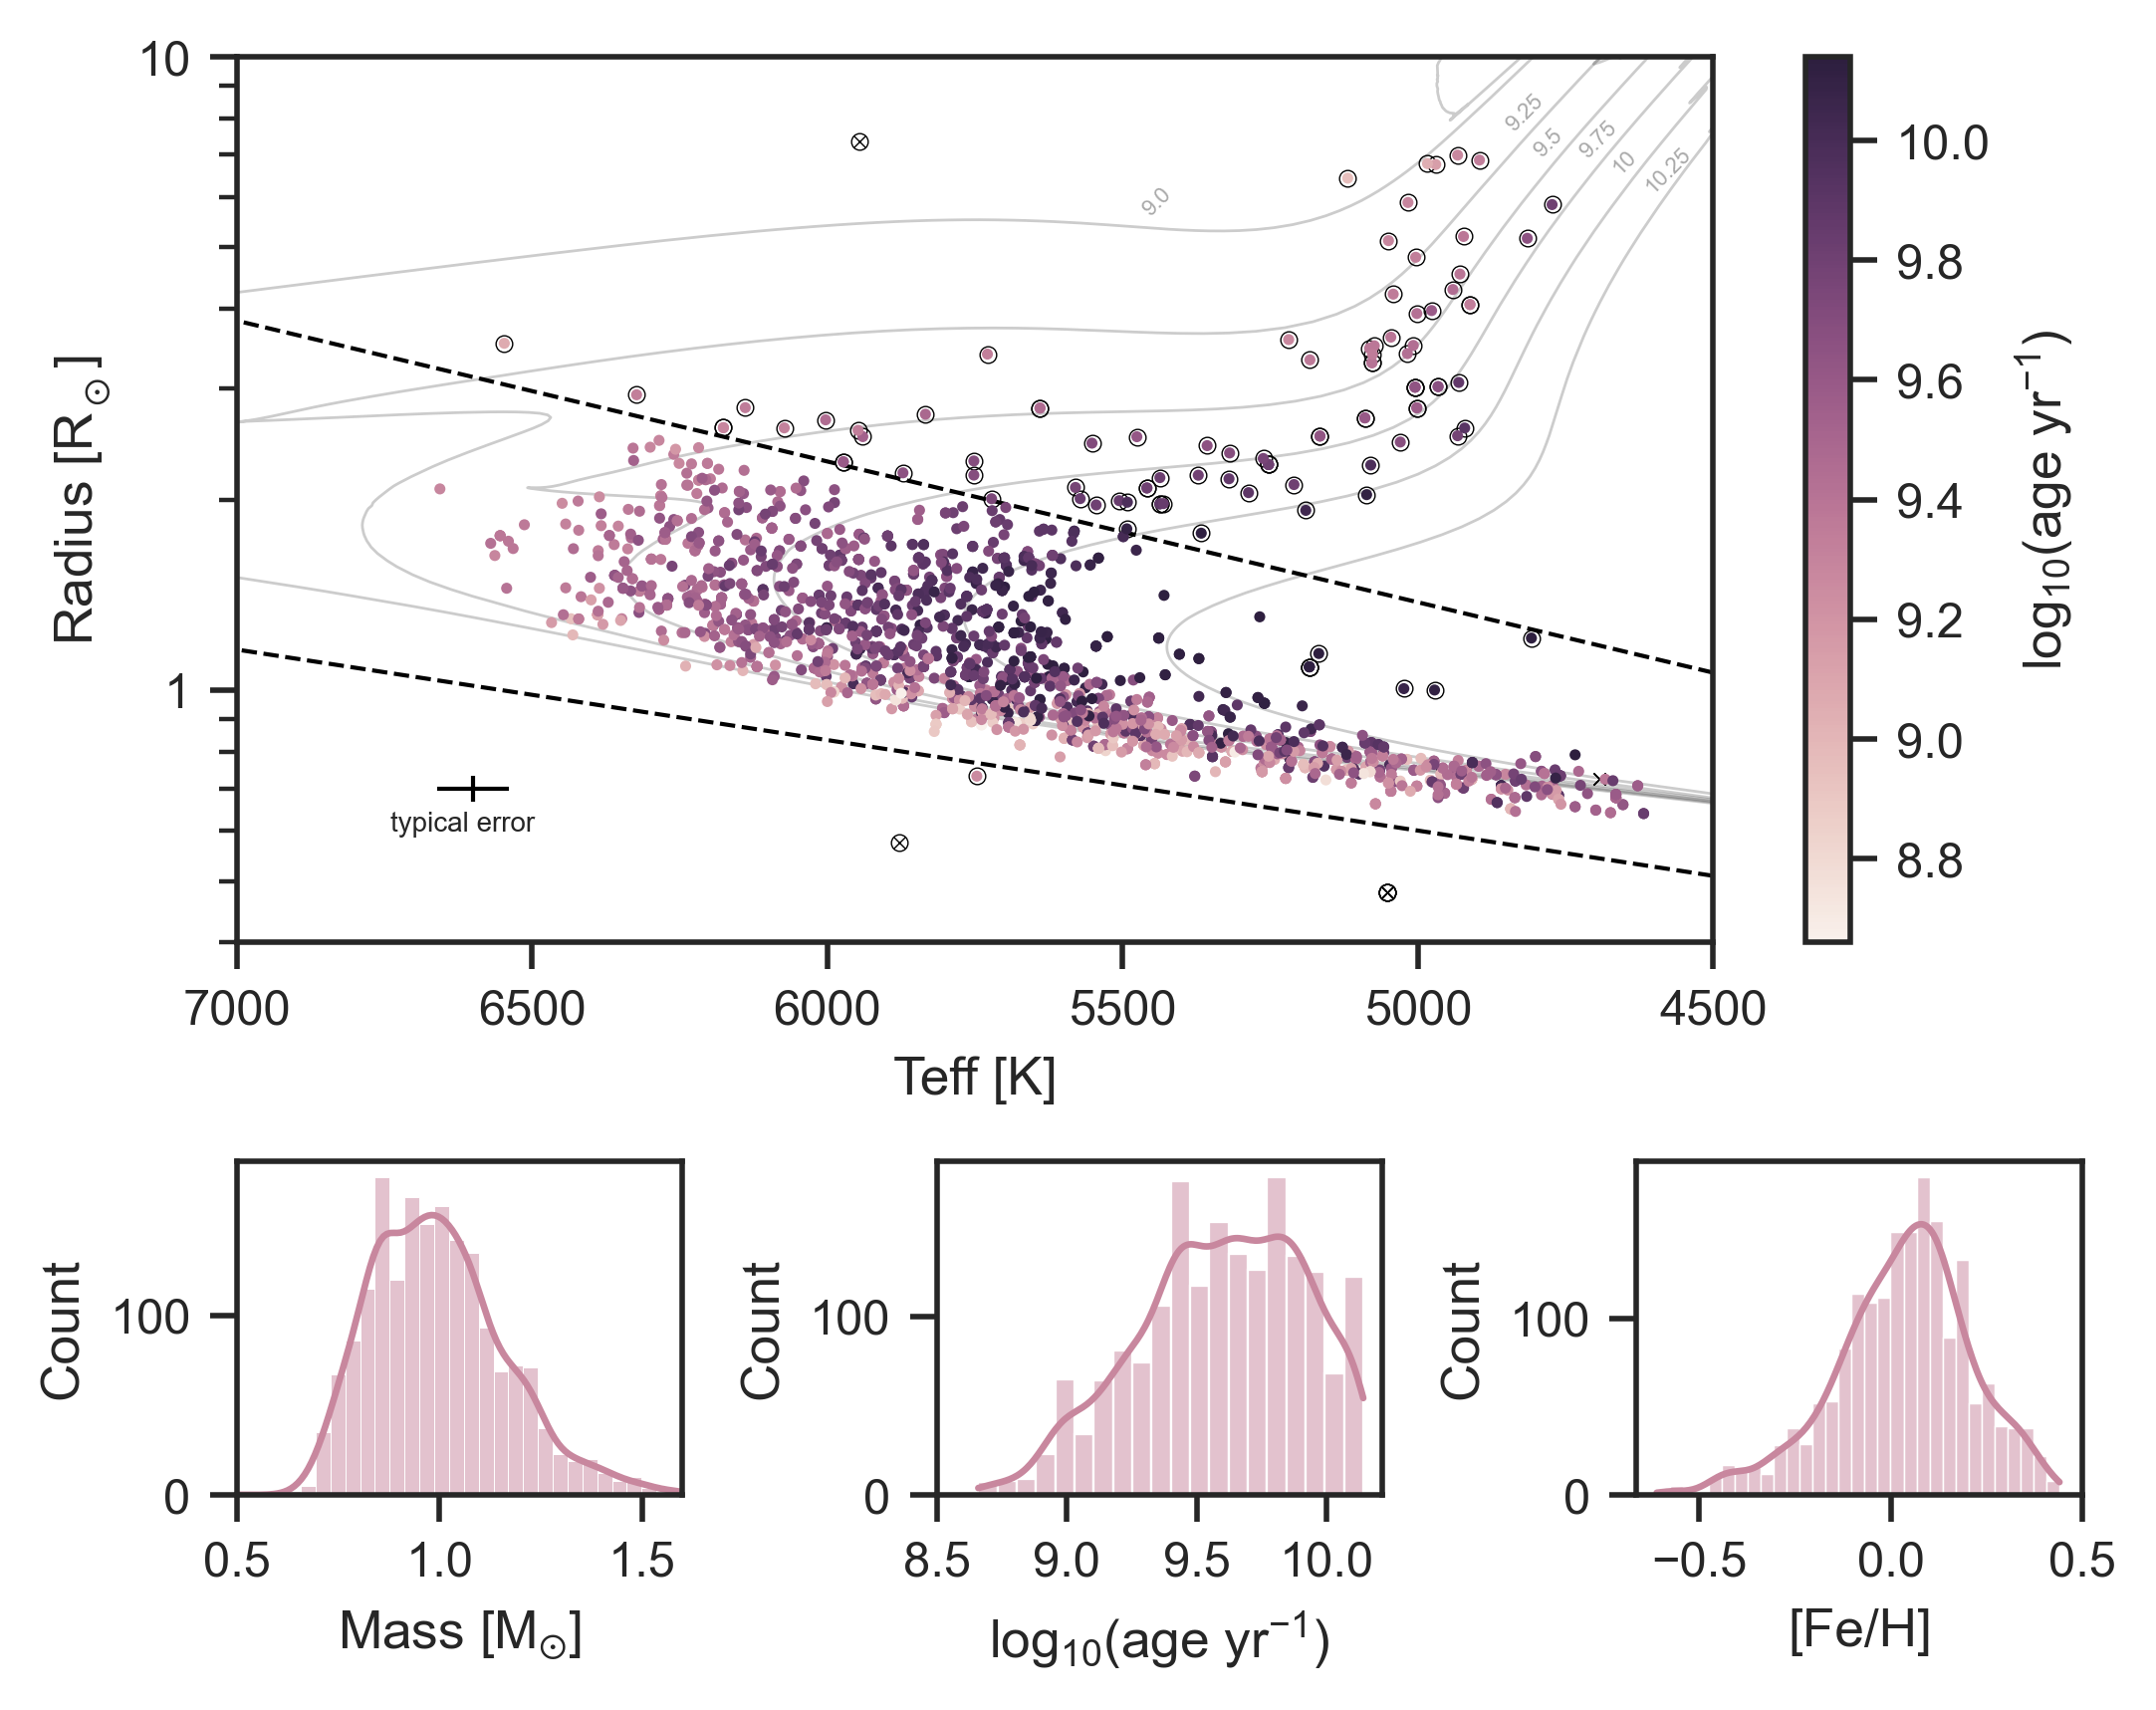

In [6]:
def maxage_teff(rstar):
    arg = (mistp['log10_isochrone_age_yr']==10.25)&(mistp['EEP']<500)
    f = interpolate.interp1d(10.**mistp['log_R'][arg], 
                             10.**mistp['log_Teff'][arg], 
                             kind='cubic', fill_value='extrapolate')
    return f(rstar)


def hrd_plot(fig_path=None):

    _teff = np.linspace(4500,7000,10)

    #We wish to remove stars that obviously fall below the main sequence as these may have unreliable stellar parameters
    m_onms = cks['f18_R'] > 10.**((cks['f18_Teff']-5500)/7000 - 0.15)
    #Our study will focus stars which have not evolved far off the main sequence
    m_unevolved = cks['f18_R'] < 10.**((cks['f18_Teff']-5500)/4500 + 0.25)
    #Some cool stars appear to be elevated from the main-sequence, corresponding to ages older than the universe
    #even if they are metal-rich.
    m_unelevated = cks['f18_Teff'] > maxage_teff(cks['f18_R'])

    #Combining masks
    m_ms = m_onms&m_unevolved&m_unelevated

    #Plotting the HRD
    fig = plt.figure(figsize=(5*1.1,4*1.1), dpi=200)
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=1)
    ax4 = plt.subplot2grid((3, 3), (2, 2), colspan=1)

    ax1.plot(cks['f18_Teff'][~np.isfinite(cks['f18_logAiso'])], cks['f18_R'][~np.isfinite(cks['f18_logAiso'])], 'kx', ms=2, mew=0.25)
    ax1.plot(cks['f18_Teff'][~m_ms], cks['f18_R'][~m_ms], 'ko', mfc="None", ms=3, mew=0.25)
    scpl = ax1.scatter(cks['f18_Teff'], cks['f18_R'], c=cks['f18_logAiso'], s=4, cmap=cmap, lw=0, zorder=999)

    ax1.plot(_teff, 10.**((_teff-5500)/4500 + 0.25), '--', color='k', lw=0.75) #upper boundary
    ax1.plot(_teff, 10.**((_teff-5500)/7000 - 0.15), '--', color='k', lw=0.75) #lower boundary

    for la in [9.,9.25,9.5,9.75,10,10.25]:
        __ = mist['log10_isochrone_age_yr']==la
        ax1.plot(10.**mist['log_Teff'][__], 10.**mist['log_R'][__], color='k', alpha=0.2, lw=0.5)
        __ &= (mist['EEP']==505)
        ax1.text(10.**mist['log_Teff'][__]+30, 1.05*10.**mist['log_R'][__], 
                 str(la), rotation=45, color='darkgrey', size=4)

    ax1.errorbar(6600,0.7, 
                 xerr=np.nanmedian(cks['f18_E_Teff']),
                 yerr=np.nanmedian(cks['f18_E_R']),
                 fmt='.', ms=0, color='k', lw=0.75)
    ax1.text(6740,0.6,'typical error',size=5)

    ax1.set_xlabel('Teff [K]')
    ax1.set_ylabel(r'Radius [$\mathregular{R_\odot}$]')
    ax1.set_xlim(7000,4500)
    ax1.semilogy()
    ax1.set_ylim(0.4,10)
    ax1.set_yticks([1,10])
    ax1.set_yticklabels(['1','10'])
    fig.colorbar(scpl, label=r'log$_\mathregular{10}$(age yr$^\mathregular{-1}$)', ax=ax1)

    sns.histplot(cks['f18_Miso'][m_ms], kde=True, ax=ax2, color=cpal[1])
    sns.histplot(cks['f18_logAiso'][m_ms], kde=True, ax=ax3, color=cpal[1])
    sns.histplot(cks['f18_[Fe/H]'][m_ms], kde=True, ax=ax4, color=cpal[1])

    ax2.set_xlim(0.5,1.6)
    ax3.set_xticks([8.5,9,9.5,10])
    ax4.set_xticks([-0.5,0,0.5])
    ax2.set_xlabel(r'Mass [M$_\mathregular{\odot}$]')
    ax3.set_xlabel(r'log$_\mathregular{10}$(age yr$^\mathregular{-1}$)')
    ax4.set_xlabel(r'[Fe/H]')

    plt.tight_layout()
    
    if fig_path:
        plt.savefig(fig_path)
    plt.show()

    return m_ms, m_onms, m_unevolved, m_unelevated

m_ms, m_onms, m_unevolved, m_unelevated = hrd_plot() #Masks to be used later

### Defining new columns and masks
Masks will be used to construct various subsamples

In [7]:
# Computing additional columns
cks['d20_ruwe'][cks['d20_ruwe']>1e4]=np.inf #There are two sources that are significant outliers in RUWE (>1e20)
cks['f18_depth_ppm'] = (cks['f18_Rp/R*']**2.0)/1e-6
cks['single_transit_snr'] = 1.0e6*((1.0*c.R_earth.value)/(cks['f18_R']*c.R_sun.value))**2. * 1.0/cks['stlr_rrmscdpp03p0']
cks['Rcut'] = 10.**((cks['f18_Teff']-5500)/4500 + 0.25) #Fulton & Petigura use 0.2 instead of 0.25
cks['rs_prec'] = 100.*np.max([cks['f18_e_R'], cks['f18_E_R']], axis=0)/cks['f18_R'] #Fractional stellar radius precision
cks['rp_prec'] = 100.*np.max([cks['f18_e_Rp'], cks['f18_E_Rp']], axis=0)/cks['f18_Rp'] #Fractional planet radius precision
cks['nkoi'] = [np.sum(cks['f18_KOI_int']==k) for k in cks['f18_KOI_int']]
cks['f18_age_gyr'] = 10.**(cks['f18_logAiso'])/1.0e9
cks['f18_agelo_gyr'] = 10.**((cks['f18_logAiso']-cks['f18_e_logAiso']))/1.0e9
cks['f18_agehi_gyr'] = 10.**((cks['f18_logAiso']+cks['f18_E_logAiso']))/1.0e9

# Threshold parameters for masks
mstar_min, mstar_max = 0.75, 1.25
period_max = 100.
r8_max = 1.1
rcf_max = 1.05
abs_feh_max = 0.3
ruwe_max = 1.4
ag_max = 2
av_max = 0.5
gkp_max = 1.0
snr_min = 0.25
dlogage_max = 1.0
rperr_max = 0.2
ageerr_max = 0.25
rtau_min = 0.6
koiscore_min = 0.8

print(len(cks), 'planets')

# Remove False Positives
m_disp = cks['p17_Disp'] != 'FP'
print(len(cks[~m_disp]), 'planets with FP disposition')

# Remove single-planet systems
#m &= ful_planet['nplanets'] > 1
#print(len(ful_planet[m]), 'planets')

# Remove stars with flux contamination determined from Gaia
m_r8 = cks['f18_r8'] < r8_max
print(len(cks[~m_r8]), 'planets fail r8 cut')

# Exclude stars with flux contamination from follow-up high-res imaging
m_rcf = np.invert(cks['f18_RCF'] >= rcf_max)
print(len(cks[~m_rcf]), 'planets fail RCF cut')

# Exclude any subgiants or giants
m_ms = m_onms & m_unevolved & m_unelevated
print(len(cks[~m_ms]), 'planets fail stellar radius cut')

# Exclude long period planets
m_period = cks['f18_P'] < period_max
print(len(cks[~m_period]), 'planets fail period cut')

# Limit the stellar masses
m_mass = (mstar_min<=cks['f18_Miso']) & (cks['f18_Miso']<=mstar_max)
print(len(cks[~m_mass]), 'planets fail stellar mass cut')

# Limit the metallicity
m_feh = abs(cks['f18_[Fe/H]'])<abs_feh_max
print(len(cks[~m_feh]), 'planets fail stellar metallicity cut')

# No transit depth disagreement between FP2018 and DR25
m_depth = abs(cks['f18_depth_ppm'] - cks['dr25_koi_depth'])<10000
print(len(cks[~m_depth]), 'planets fail transit depth agreement cut')

# Signal-to-noise cut
m_snr = cks['single_transit_snr'] > snr_min
print(len(cks[~m_snr]), 'planets fail SNR cut')

# Age disagreement between FP18 and B20
m_deltaage = abs(cks['f18_logAiso'] - cks['b20_log10_iso_age'])< dlogage_max
print(len(cks[~m_deltaage]), 'planets fail age agreement test')

# Precise ages
m_ageerr = np.all(np.array([cks['f18_e_logAiso'], cks['f18_E_logAiso']])<ageerr_max, axis=0)
print(len(cks[~m_ageerr]), 'planets fail age precision cut')

# Well-determined planet radii
m_rperr = np.all(np.array([cks['f18_e_Rp']/cks['f18_Rp'], cks['f18_E_Rp']/cks['f18_Rp']])<rperr_max, axis=0)
print(len(cks[~m_rperr]), 'planets fail radius precision cut')

# Small planets
m_rp = cks['f18_Rp']<10.0
print(len(cks[~m_rp]), 'planets fail radius cut')

# RUWE cut
m_ruwe = cks['d20_ruwe']<ruwe_max
print(len(cks[~m_ruwe]), 'planets fail RUWE cut')

# Stars with discrepant Kp and Gaia mags
m_deltamag = abs(cks['gaia_phot_g_mean_mag']-cks['dr25_koi_kepmag'])<gkp_max
print(len(cks[~m_deltamag]), 'planets fail Gaia-Kepler brightness agreement test')

# Stars with low Gaia reddening
#m_red = cks['gaia_a_g_val']<ag_max
m_red = cks['l20_Av']<av_max
print(len(cks[~m_red]), 'planets fail reddening cut')

# Stars with discrepant Gaia and isochrone parallaxes
m_plx = abs(cks['f18_plx']-cks['f18_plxspec'])/np.min(np.array([cks['f18_e_plxspec'],cks['f18_E_plxspec']]), axis=0) < 4
print(len(cks[~m_plx]), 'planets fail parallax agreement test')

# Planets with grazing transits
m_nongrazing = cks['p20_Rtau'] >= rtau_min
print(len(cks[~m_nongrazing]), 'planets with grazing transits')

# KOI score
m_koiscore = cks['dr25_koi_score']>koiscore_min

m = m_disp&\
    m_r8&\
    m_rcf&\
    m_ms&\
    m_period&\
    m_mass&\
    m_feh&\
    m_rperr&\
    m_rp&\
    m_ruwe&\
    m_deltamag&\
    m_plx&\
    m_nongrazing & m_red & m_depth #& m_snr  & m_deltaage


common_cuts = m_ms & m_disp & m_period & m_rp & m_rperr & (cks['f18_Miso']>0.5) #& m_koiscore
cc = m_ms & m_disp & m_period & m_rp & m_rperr & (cks['f18_Miso']>0.5)

print("Base sample")
print(len(cks[common_cuts]), 'planets remaining after cuts in base sample')
print(len(np.unique(np.array(cks['f18_KOI_int'][common_cuts]))), 'unique hosts remaining after cuts in base sample')

print("Filtered sample")
print(len(cks[m]), 'planets remaining after cuts in filtered sample')
print(len(np.unique(np.array(cks['f18_KOI_int'][m]))), 'unique hosts remaining after cuts in filtered sample')

print("Hot star sample")
hot_stars = common_cuts & (cks['f18_Teff']>5500.)
print(len(cks[hot_stars]), 'planets remaining after cuts in filtered sample')
print(len(np.unique(np.array(cks['f18_KOI_int'][hot_stars]))), 'unique hosts remaining after cuts in filtered sample')

mask_dict = {1: 'False positive disposition',
             2: 'Flux contamination from Gaia',
             3: 'Flux contamination from imaging',
             4: 'Evolved stars',
             5: 'Long periods', 
             6: 'Stellar mass cut',
             7: 'Stellar metallicity cut', 
             8: 'Transit depth disagreement', 
             9: 'Earth-sized transit SNR',
             10: 'Age disagreement between F18 and B20', 
             11: 'Low precision in planet radius',
             12: 'Small planets', 
             13: 'Gaia RUWE > 1.4', 
             14: 'Discrepant Gaia G and Kepler Kp magnitudes', 
             15: 'Large Gaia reddening',
             16: 'Discrepant trigonometric and spectroscopic parallaxes',
             17: 'Grazing transits'}

1913 planets
149 planets with FP disposition
137 planets fail r8 cut
78 planets fail RCF cut
105 planets fail stellar radius cut
223 planets fail period cut
253 planets fail stellar mass cut
219 planets fail stellar metallicity cut
179 planets fail transit depth agreement cut
233 planets fail SNR cut
184 planets fail age agreement test
814 planets fail age precision cut
96 planets fail radius precision cut
153 planets fail radius cut
234 planets fail RUWE cut
140 planets fail Gaia-Kepler brightness agreement test
216 planets fail reddening cut
99 planets fail parallax agreement test
601 planets with grazing transits
Base sample
1443 planets remaining after cuts in base sample
871 unique hosts remaining after cuts in base sample
Filtered sample
732 planets remaining after cuts in filtered sample
466 unique hosts remaining after cuts in filtered sample
Hot star sample
997 planets remaining after cuts in filtered sample
622 unique hosts remaining after cuts in filtered sample


### Age validation plots

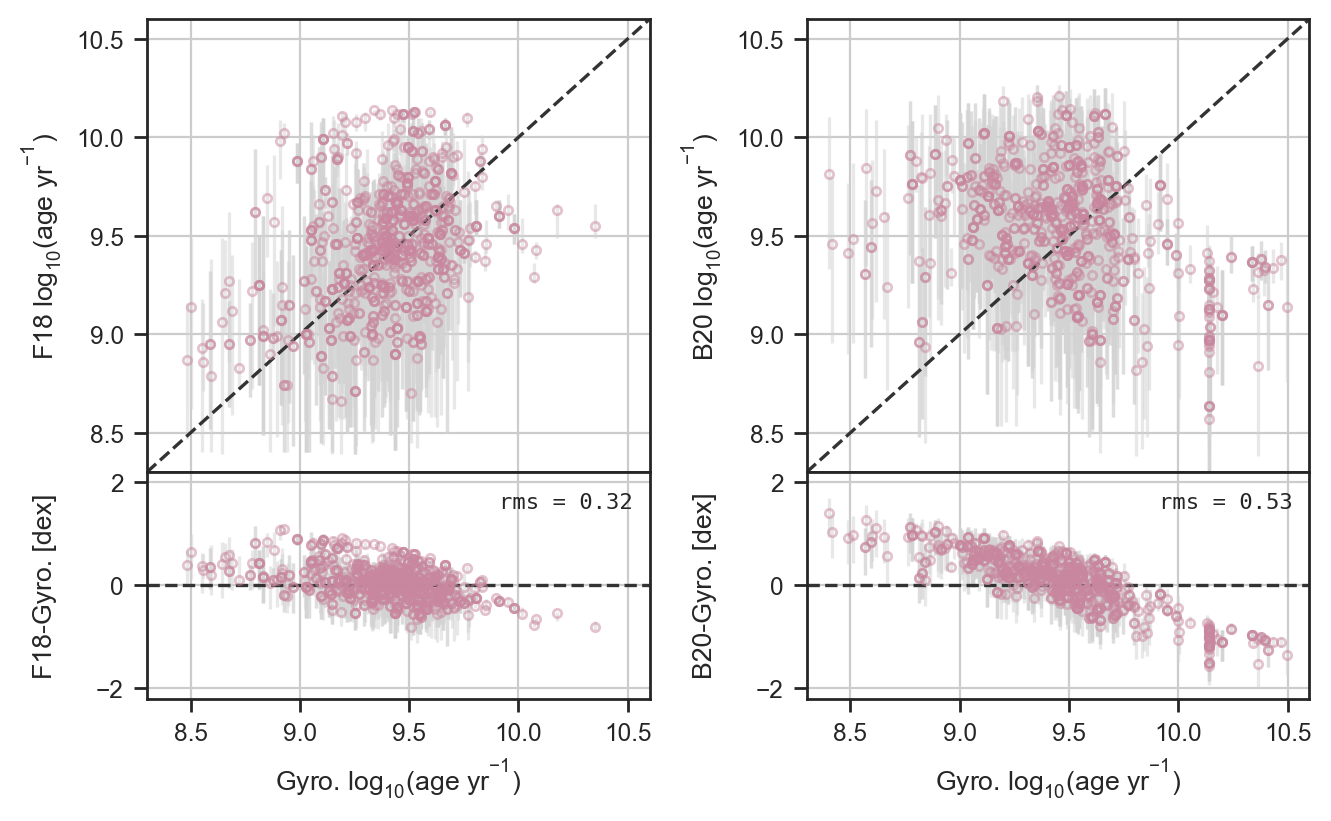

In [10]:
# ******************
def gyro_age_validation_plot(fig_path=None,
                            ebar_kwargs = {'ecolor':'lightgrey', 'mfc':'None', 'ms':3, 'fmt':'o', 'alpha':0.5, 'rasterized':True}):

    
    arg = common_cuts & (np.isfinite(cks['prot']))
    
    x1 = cks['f18_logAiso'][arg]
    x1_err = [cks['f18_e_logAiso'][arg],cks['f18_E_logAiso'][arg]]
    x2 = cks['b20_log10_iso_age'][arg]
    x2_err = [cks['b20_e_log10_iso_age'][arg], cks['b20_E_log10_iso_age'][arg]]
    x3 = cks['sd_age'][arg]
    x3_err = np.zeros(len(x3))

    x4 = cks['sd_age_phot'][arg]
    x4_err = np.zeros(len(x4))


    x1x3_err = [np.sqrt(x1_err[0]**2+x3_err[0]**2), np.sqrt(x1_err[1]**2+x3_err[1]**2)]
    x2x3_err = [np.sqrt(x2_err[0]**2+x3_err[0]**2), np.sqrt(x2_err[1]**2+x3_err[1]**2)]


    x2x4_err = [np.sqrt(x2_err[0]**2+x4_err[0]**2), np.sqrt(x2_err[1]**2+x4_err[1]**2)]

    xmin,xmax = 8.3,10.6

    fig = plt.figure(constrained_layout=False, figsize=(7.5,4.5))
    gs1 = fig.add_gridspec(nrows=3, ncols=6, hspace=0, wspace=2.5)
    ax1 = fig.add_subplot(gs1[:-1, 0:3])
    ax2 = fig.add_subplot(gs1[-1, 0:3])
    ax3 = fig.add_subplot(gs1[:-1, 3:])
    ax4 = fig.add_subplot(gs1[-1, 3:])


    for ax in [ax1,ax2,ax3,ax4]:
        ax.grid(True)
        ax.set_xlim(xmin,xmax)

    for ax in [ax1,ax3]:
        ax.plot([xmin,xmax],[xmin,xmax],'--',color='#333333')
        ax.set_xticklabels([])
        ax.set_ylim(xmin,xmax)

    for ax in [ax2,ax4]:
        ax.axhline(0, ls='--', color="#333333")    
        ax.set_ylim(-2.2,2.2)

    #for ax in [ax3,ax4]:
    #    ax.set_yticklabels([])

    ax1.errorbar(x3, x1, xerr=x3_err, yerr=x1_err, color=cpal[1], **ebar_kwargs)
    ax2.errorbar(x3, x1-x3, yerr=x1x3_err, color=cpal[1], **ebar_kwargs)


    #ax3.errorbar(x3, x2, xerr=x3_err, yerr=x2_err, color=cpal[2], **ebar_kwargs)
    #ax4.errorbar(x3, x2-x3, yerr=x2x3_err, color=cpal[2], **ebar_kwargs)

    ax3.errorbar(x4, x2, xerr=x4_err, yerr=x2_err, color=cpal[1], **ebar_kwargs)
    ax4.errorbar(x4, x2-x4, yerr=x2x4_err, color=cpal[1], **ebar_kwargs)

    ax2.text(0.7,0.84,'rms = '+str(np.nanstd(x1-x3).round(2)),
             family='monospace', 
             weight='light',
             size=8,
             transform=ax2.transAxes)

    ax4.text(0.7,0.84,'rms = '+str(np.nanstd(x2-x4).round(2)),
             family='monospace', 
             weight='light',
             size=8,
             transform=ax4.transAxes)


    ax2.set_xlabel(r'Gyro. $\mathregular{log_{10}(age~yr^{-1})}$')
    ax4.set_xlabel(r'Gyro. $\mathregular{log_{10}(age~yr^{-1})}$')
    ax1.set_ylabel(r'F18 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax2.set_ylabel(r'F18 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax3.set_ylabel(r'B20 $\mathregular{log_{10}(age~yr^{-1})}$')

    #ax2.set_ylabel(r'$\mathregular{\Delta log_{10}(age~yr^{-1})}$')
    ax2.set_ylabel('F18-Gyro. [dex]', labelpad=14)
    ax4.set_ylabel('B20-Gyro. [dex]', labelpad=14)

    if fig_path:
        plt.savefig(fig_path, bbox_inches='tight')
    
    plt.show()
    return

gyro_age_validation_plot('../figures/gyrochronology.pdf')

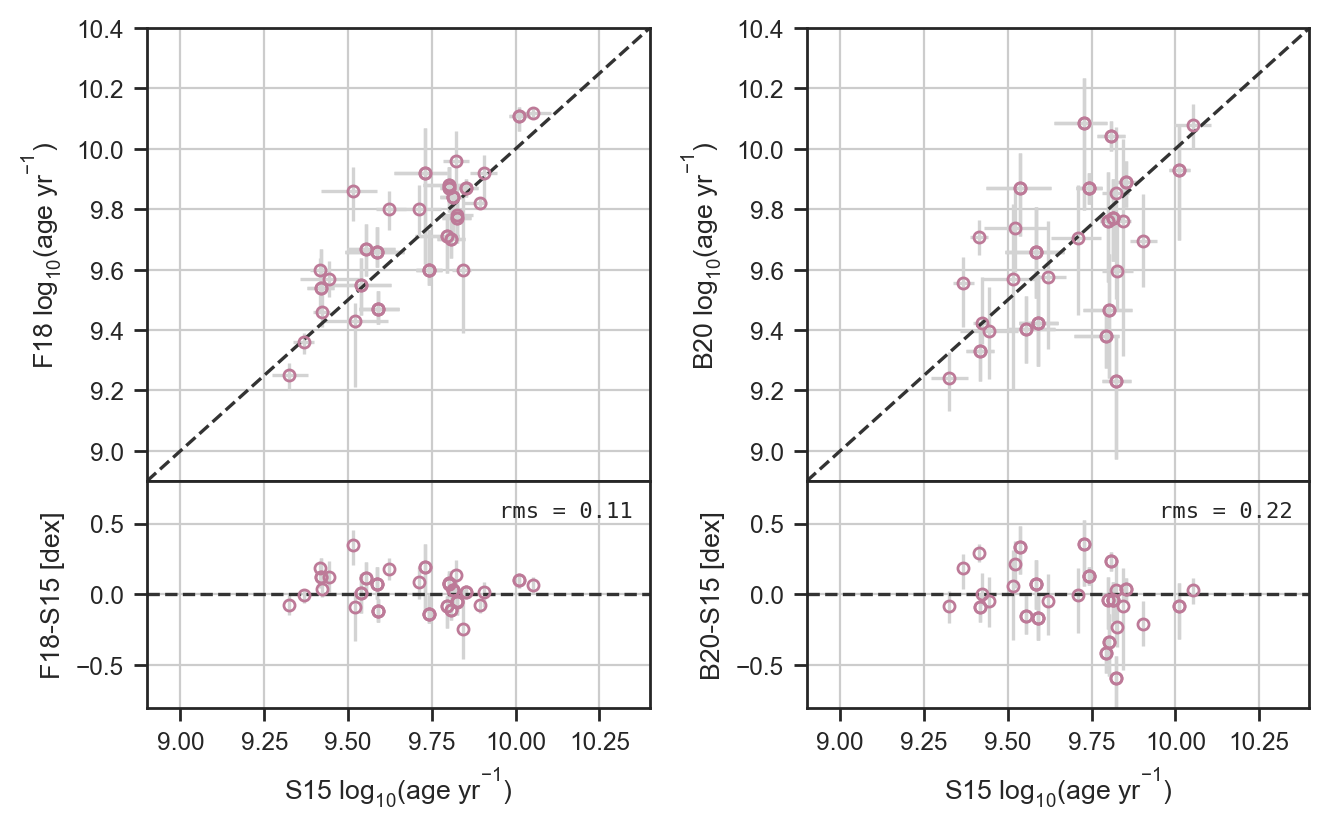

In [12]:
import matplotlib.gridspec as gridspec
cpal = sns.cubehelix_palette(6)

def asteroseismic_plot(fig_path=None, ebar_kwargs = {'ecolor': 'lightgrey', 'mfc':'None', 'ms': 4, 'fmt':'o'}):

    x1 = cks['f18_logAiso']
    x1_err = [cks['f18_e_logAiso'],cks['f18_E_logAiso']]
    x2 = cks['b20_log10_iso_age']
    x2_err = [cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']]
    x3 = np.log10(cks['s15_Age']*1.0e9)
    x3_err = [x3-np.log10(1.0e9*(cks['s15_Age']-cks['s15_e_Age'])),
              np.log10(1.0e9*(cks['s15_Age']+cks['s15_E_Age']))-x3]

    x1x3_err = [np.sqrt(x1_err[0]**2+x3_err[0]**2), np.sqrt(x1_err[1]**2+x3_err[1]**2)]
    x2x3_err = [np.sqrt(x2_err[0]**2+x3_err[0]**2), np.sqrt(x2_err[1]**2+x3_err[1]**2)]

    xmin,xmax = 8.9,10.4

    fig = plt.figure(constrained_layout=False, figsize=(7.5,4.5))
    gs1 = fig.add_gridspec(nrows=3, ncols=6, hspace=0, wspace=2.5)
    ax1 = fig.add_subplot(gs1[:-1, 0:3])
    ax2 = fig.add_subplot(gs1[-1, 0:3])
    ax3 = fig.add_subplot(gs1[:-1, 3:])
    ax4 = fig.add_subplot(gs1[-1, 3:])


    for ax in [ax1,ax2,ax3,ax4]:
        ax.grid(True)
        ax.set_xlim(xmin,xmax)

    for ax in [ax1,ax3]:
        ax.plot([xmin,xmax],[xmin,xmax],'--',color='#333333')
        ax.set_xticklabels([])
        ax.set_ylim(xmin,xmax)

    for ax in [ax2,ax4]:
        ax.axhline(0, ls='--', color="#333333")    
        ax.set_ylim(-0.8,0.8)

    ax1.errorbar(x3, x1, xerr=x3_err, yerr=x1_err, color=cpal[2], **ebar_kwargs)
    ax2.errorbar(x3, x1-x3, yerr=x1x3_err, color=cpal[2], **ebar_kwargs)
    ax3.errorbar(x3, x2, xerr=x3_err, yerr=x2_err, color=cpal[2], **ebar_kwargs)
    ax4.errorbar(x3, x2-x3, yerr=x2x3_err, color=cpal[2], **ebar_kwargs)

    ax2.text(0.7,0.84,'rms = '+str(np.nanstd(x1-x3).round(2)),
             family='monospace', 
             weight='light',
             size=8,
             transform=ax2.transAxes)

    ax4.text(0.7,0.84,'rms = '+str(np.nanstd(x2-x3).round(2)),
             family='monospace', 
             weight='light',
             size=8,
             transform=ax4.transAxes)


    ax2.set_xlabel(r'S15 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax4.set_xlabel(r'S15 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax1.set_ylabel(r'F18 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax2.set_ylabel(r'F18 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax3.set_ylabel(r'B20 $\mathregular{log_{10}(age~yr^{-1})}$')

    ax2.set_ylabel('F18-S15 [dex]')
    ax4.set_ylabel('B20-S15 [dex]')

    if fig_path:
        plt.savefig(fig_path, bbox_inches='tight')
        
    plt.show()
    return

asteroseismic_plot('../figures/asteroseismic.pdf')

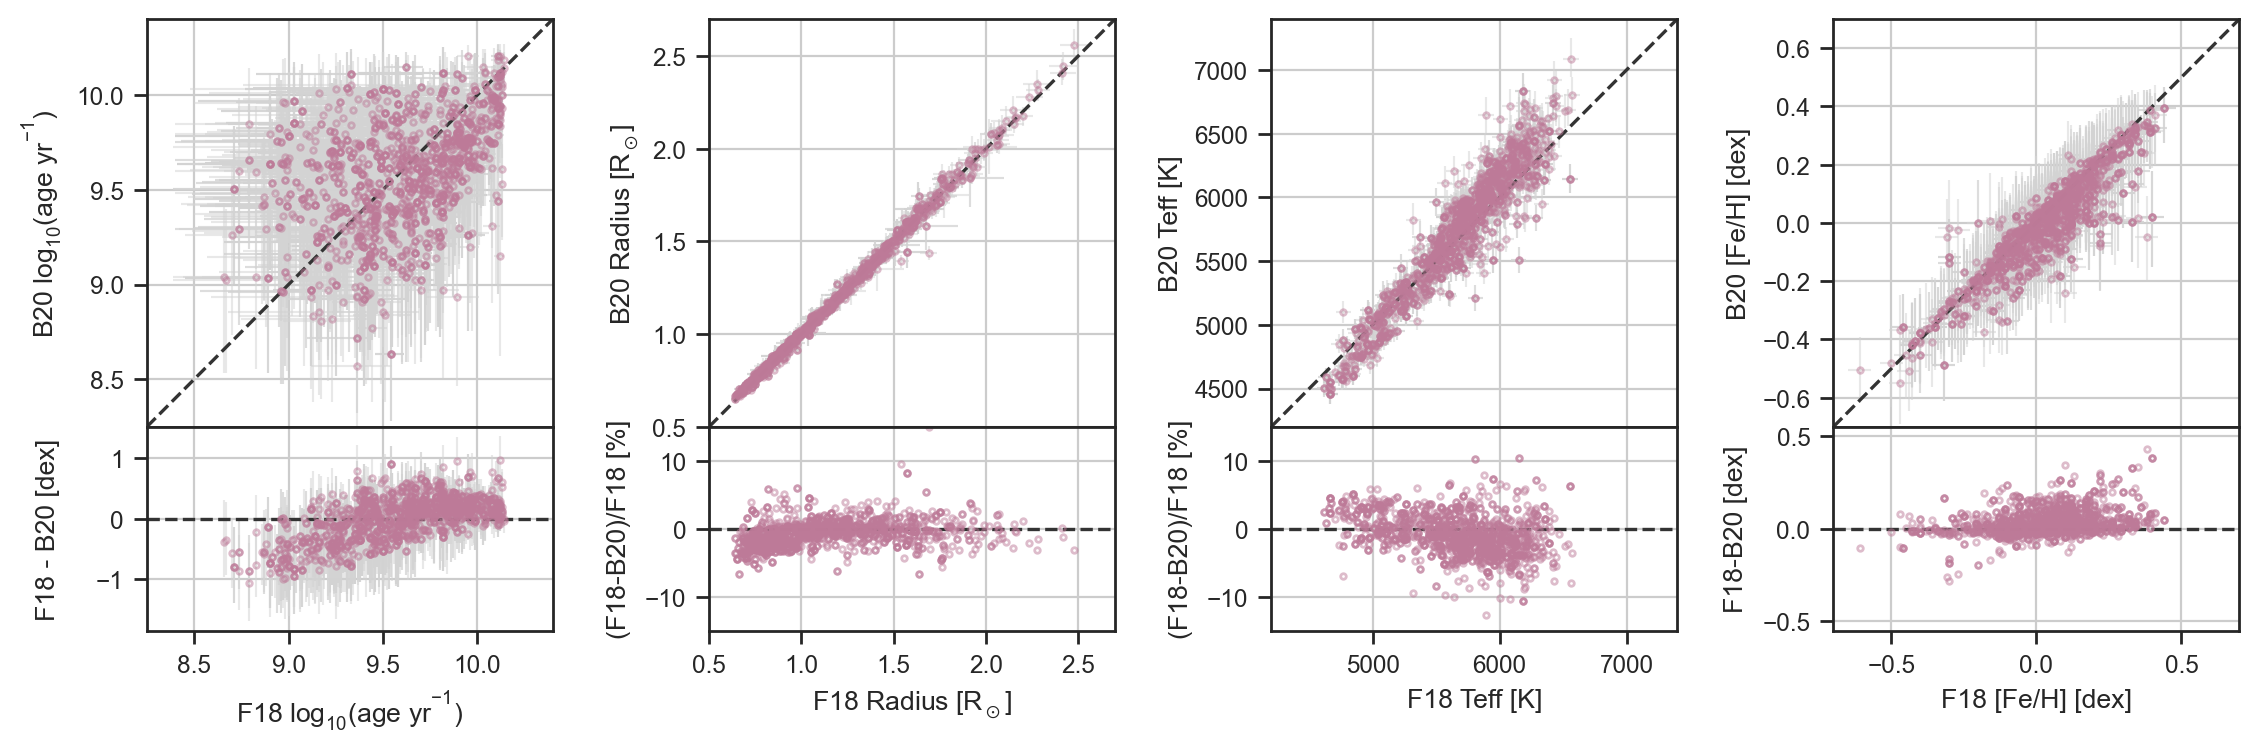

In [13]:
def gkspc_comparison(fig_path=None,
                     ebar_kwargs = {'ecolor': 'lightgrey', 'mfc':'None', 'ms': 4, 'fmt':'.', 'alpha':0.5, 'lw':0.75, 'rasterized': True}):


    x1 = cks['f18_logAiso'][common_cuts]
    x1_err = [cks['f18_e_logAiso'][common_cuts],cks['f18_E_logAiso'][common_cuts]]
    x2 = cks['b20_log10_iso_age'][common_cuts]
    x2_err = [cks['b20_e_log10_iso_age'][common_cuts], cks['b20_E_log10_iso_age'][common_cuts]]

    x3 = cks['f18_R'][common_cuts]
    x3_err = [cks['f18_e_R'][common_cuts],cks['f18_E_R'][common_cuts]]
    x4 = cks['b20_iso_rad'][common_cuts]
    x4_err = [-cks['b20_iso_rad_err2'][common_cuts], cks['b20_iso_rad_err1'][common_cuts]]

    x5 = cks['f18_Teff'][common_cuts]
    x5_err = [cks['f18_e_Teff'][common_cuts],cks['f18_E_Teff'][common_cuts]]
    x6 = cks['b20_iso_teff'][common_cuts]
    x6_err = [-cks['b20_iso_teff_err2'][common_cuts], cks['b20_iso_teff_err1'][common_cuts]]

    x7 = cks['f18_[Fe/H]'][common_cuts]
    x7_err = [cks['f18_e_[Fe/H]'][common_cuts],cks['f18_E_[Fe/H]'][common_cuts]]
    x8 = cks['b20_iso_feh'][common_cuts]
    x8_err = [-cks['b20_iso_feh_err2'][common_cuts], cks['b20_iso_feh_err1'][common_cuts]]


    x1x2_err = [np.sqrt(x1_err[0]**2+x2_err[0]**2), np.sqrt(x1_err[1]**2+x2_err[1]**2)]
    x3x4_err = [np.sqrt(x3_err[0]**2+x4_err[0]**2), np.sqrt(x3_err[1]**2+x4_err[1]**2)]
    x5x6_err = [np.sqrt(x5_err[0]**2+x6_err[0]**2), np.sqrt(x5_err[1]**2+x6_err[1]**2)]
    x7x8_err = [np.sqrt(x7_err[0]**2+x8_err[0]**2), np.sqrt(x7_err[1]**2+x8_err[1]**2)]

    fig = plt.figure(constrained_layout=False, figsize=(0.9*7.5*2,0.9*4.5))
    gs1 = fig.add_gridspec(nrows=3, ncols=12, hspace=0, wspace=5)

    ax1 = fig.add_subplot(gs1[:-1, 0:3])
    ax2 = fig.add_subplot(gs1[-1, 0:3])
    ax3 = fig.add_subplot(gs1[:-1, 3:6])
    ax4 = fig.add_subplot(gs1[-1, 3:6])

    ax5 = fig.add_subplot(gs1[:-1, 6:9])
    ax6 = fig.add_subplot(gs1[-1, 6:9])
    ax7 = fig.add_subplot(gs1[:-1, 9:12])
    ax8 = fig.add_subplot(gs1[-1, 9:12])

    for ax in [ax1,ax3,ax5,ax7]:
        ax.set_xticklabels([])

    for ax in [ax2,ax4,ax6,ax8]:
        ax.axhline(0, ls='--', color="#333333")    

    line_kwargs = {"ls": "--", "color":"#333333"}

    ax1.plot([8.25,10.4],[8.25,10.4], **line_kwargs)
    ax1.errorbar(x1, x2, xerr=x1_err, yerr=x2_err, color=cpal[2], **ebar_kwargs)
    ax2.errorbar(x1, x1-x2, yerr=x1x2_err, color=cpal[2], **ebar_kwargs)
    ax1.set_xlim(8.25,10.4)
    ax1.set_ylim(8.25,10.4)
    ax2.set_xlim(8.25,10.4)

    xmin,xmax = 0.5,2.7
    ax3.plot([xmin,xmax],[xmin,xmax], **line_kwargs)
    ax3.errorbar(x3, x4, xerr=x3_err, yerr=x4_err, color=cpal[2], **ebar_kwargs)
    ax4.errorbar(x3, 100.*(x3-x4)/x3, color=cpal[2], **ebar_kwargs)
    ax3.set_xlim(xmin,xmax)
    ax3.set_ylim(xmin,xmax)
    ax4.set_xlim(xmin,xmax)


    xmin,xmax = 4200,7400
    ax5.plot([xmin,xmax],[xmin,xmax], **line_kwargs)
    ax5.errorbar(x5, x6, xerr=x5_err, yerr=x6_err, color=cpal[2], **ebar_kwargs)
    ax6.errorbar(x5, 100.*(x5-x6)/x5, color=cpal[2], **ebar_kwargs)
    ax5.set_xlim(xmin,xmax)
    ax5.set_ylim(xmin,xmax)
    ax6.set_xlim(xmin,xmax)

    xmin,xmax = -0.7,0.7
    ax7.plot([xmin,xmax],[xmin,xmax], **line_kwargs)
    ax7.errorbar(x7, x8, xerr=x7_err, yerr=x8_err, color=cpal[2], **ebar_kwargs)
    ax8.errorbar(x7, x7-x8, color=cpal[2], **ebar_kwargs)
    ax7.set_xlim(xmin,xmax)
    ax7.set_ylim(xmin,xmax)
    ax8.set_xlim(xmin,xmax)

    ax1.set_ylabel(r'B20 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax2.set_xlabel(r'F18 $\mathregular{log_{10}(age~yr^{-1})}$')
    ax2.set_ylabel('F18 - B20 [dex]', labelpad=13)

    ax3.set_ylabel(r'B20 Radius $\mathregular{[R_\odot]}$')
    ax4.set_xlabel(r'F18 Radius $\mathregular{[R_\odot]}$')
    ax4.set_ylabel('(F18-B20)/F18 [%]', labelpad=5)
    ax4.set_ylim(-15,15)

    ax5.set_ylabel('B20 Teff [K]')
    ax6.set_xlabel('F18 Teff [K]')
    ax6.set_ylabel('(F18-B20)/F18 [%]', labelpad=5)
    ax6.set_ylim(-15,15)

    ax7.set_ylabel('B20 [Fe/H] [dex]')
    ax8.set_xlabel('F18 [Fe/H] [dex]')
    ax8.set_ylabel('F18-B20 [dex]', labelpad=5)
    ax8.set_ylim(-0.55,0.55)

    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
        ax.grid(True)

    if fig_path:
        plt.savefig(fig_path, bbox_inches='tight')
        
    plt.show()
    return

gkspc_comparison('../figures/gkspc.pdf')

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10


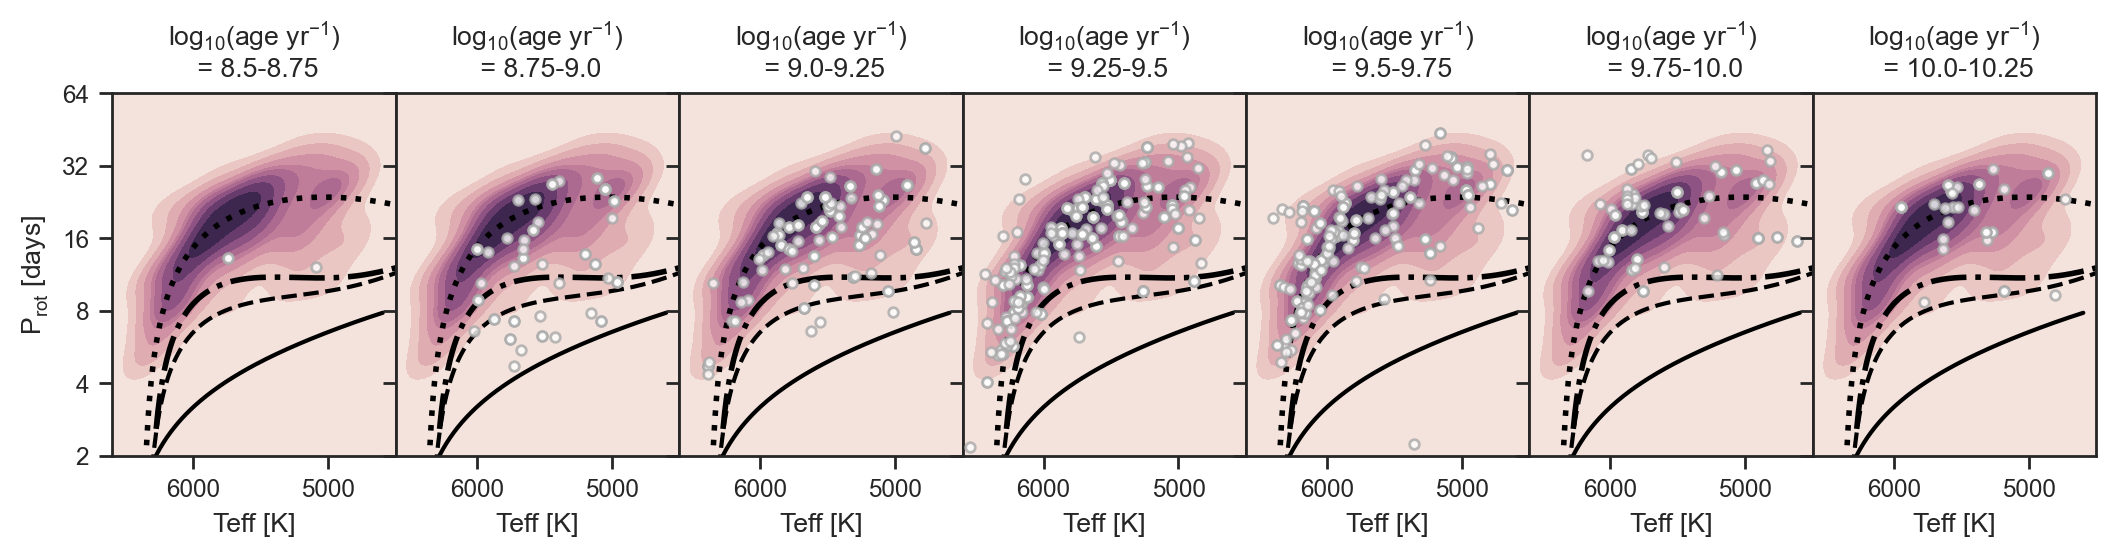

In [14]:
def gyro_panels_plot(fig_path=None):

    age_bins = np.arange(8.5,10.5,0.25)

    fig, axes = plt.subplots(1,len(age_bins)-1, 
                           sharey=True, 
                           figsize=(0.8*2*len(age_bins),0.8*3))


    for i in range(len(age_bins)-1):

        ax = axes[i]

        arg = (np.isfinite(cks['f18_Teff'])) & (np.isfinite(cks['Prot']))
        sns.kdeplot(x=cks['f18_Teff'][arg], y=np.log10(cks['Prot'][arg]), fill=True, thresh=0, cmap=cmap, ax=ax)


        newarg = (age_bins[i] <= cks['f18_logAiso']) & (cks['f18_logAiso'] < age_bins[i+1])


        sns.scatterplot(x=cks['f18_Teff'][newarg], y=np.log10(cks['Prot'][newarg]), 
                    color='white', 
                    edgecolor='darkgrey', 
                    alpha=0.8, 
                    s=12, 
                    linewidth=1.,
                    zorder=999,
                    ax=ax)

        bprp = np.linspace(0,5,1000)
        teff = curtis_bprp_teff(bprp)

        ax.plot(teff, np.log10(curtis_gyrochrone(bprp, kind='pleiades-quad')), 'k-', lw=1.5)
        ax.plot(teff, np.log10(curtis_gyrochrone(bprp, kind='praesepe')), 'k--', lw=1.5)
        ax.plot(teff, np.log10(curtis_gyrochrone(bprp, kind='ngc6811')), 'k-.', lw=2)
        ax.plot(teff, np.log10(curtis_gyrochrone(bprp, kind='ngc6819+ruprecht147')), 'k:', lw=2)


        ax.set_xlabel(r'Teff [K]')
        ax.set_xlim(6600,4500)
        ax.set_ylim(np.log10(2),np.log10(64))
        ax.set_title(r'log$_\mathregular{10}$(age yr$^\mathregular{-1}$)'+'\n = '+str(age_bins[i])+'-'+str(age_bins[i+1]))

    axes[0].set_ylabel(r'$\mathregular{P_{rot}}$ [days]')
    yticks = [2,4,8,16,32,64]
    plt.yticks(np.log10(yticks), [str(yt) for yt in yticks])

    plt.subplots_adjust(wspace=0.0)
    if fig_path:
        plt.savefig(fig_path)
    plt.show()
    return
    
gyro_panels_plot('../figures/gyro.pdf')